In [1]:
import torch, json
import pytorch_lightning as pl
# suppress warnings
import warnings

warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings(
    "ignore",
    category=UserWarning,
    module="pytorch_lightning.trainer.data_loading",
    lineno=102,
)

from rdkit import Chem
from rdkit.Chem import Descriptors

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from bondnet.model.metric import WeightedL1Loss, WeightedMSELoss, WeightedSmoothL1Loss
from torchmetrics import R2Score
import seaborn as sns
sns.set(style="whitegrid")
from sklearn.metrics import r2_score

In [2]:
combine_df = pd.read_json('reactant_only_df.json')
refine_df_test = combine_df[combine_df['trn_test_index'] == 'test']
refine_df_train = combine_df[combine_df['trn_test_index'] == 'train']
refine_df_train.reset_index(inplace = True)
refine_df_train.drop(columns = ['index'], inplace=True)

/tmp/ipykernel_1836703/1181397200.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  refine_df_train.drop(columns = ['index'], inplace=True)


In [3]:
refine_df_train

,reactant_smiles,functional_group_reacted,dG_sp,trn_test_index
0,C[C@]12N[C@H]1[C@H]1O[C@]12C#N,nitrile,-28.866221,train
1,N#C[C@@]12O[C@@H]1[C@@H]1C[C@@]12O,nitrile,-28.601387,train
2,C[C@]12O[C@H]1[C@H]1N[C@]12C#N,nitrile,-25.460650,train
3,N#C[C@@H]1[C@H]2[C@@H]3C[C@H]2[C@]13O,nitrile,-21.998812,train
4,C[C@H]1[C@H]2C[C@]1(C#N)[C@H]2C,nitrile,-16.677232,train
...,...,...,...,...
15259,CCN(/C=N/C)C(N)=O,urea,1.361819,train
15260,NC(=O)NC[C@H]1CCO1,urea,9.052126,train
15261,NC(=O)NCC1CCC1,urea,9.383193,train
15262,COCCCNC(N)=O,urea,12.081217,train


In [4]:
refine_df_test.reset_index(inplace = True)
refine_df_test.drop(columns = ['index'], inplace=True)

/tmp/ipykernel_1836703/3650120708.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  refine_df_test.drop(columns = ['index'], inplace=True)


In [5]:
refine_df_test

,reactant_smiles,functional_group_reacted,dG_sp,trn_test_index
0,C[C@@H](OC(N)=O)C(N)=O,amide,14.151633,test
1,C[C@H]1CCOC(=N1)C(=O)N,amide,25.606444,test
2,COC[C@@H](CC(=O)N)C#C,amide,21.906795,test
3,O=CC#CC(=O)N,amide,24.282995,test
4,NC(=O)c1conn1,amide,10.265196,test
...,...,...,...,...
995,CC1(C)NC(=O)NC1=O,imide,13.638689,test
996,CN1C(=O)CCCC1=O,imide,10.530190,test
997,CC1=C(N)C(=O)NC1=O,imide,19.388111,test
998,N[C@H]1C=CC(=O)NC1=O,imide,8.520171,test


In [6]:
from rdkit import Chem

def calculate_num_atoms(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is not None:
        return mol.GetNumAtoms()
    else:
        return None

# Apply the function to the DataFrame
refine_df_train['reactant_natoms'] = refine_df_train['reactant_smiles'].apply(calculate_num_atoms)
refine_df_test['reactant_natoms'] = refine_df_test['reactant_smiles'].apply(calculate_num_atoms)

/tmp/ipykernel_1836703/2123115800.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  refine_df_train['reactant_natoms'] = refine_df_train['reactant_smiles'].apply(calculate_num_atoms)
/tmp/ipykernel_1836703/2123115800.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  refine_df_test['reactant_natoms'] = refine_df_test['reactant_smiles'].apply(calculate_num_atoms)


In [7]:
def calculate_num_bonds(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is not None:
        return mol.GetNumBonds()
    else:
        return None

# Apply the function to the DataFrame
refine_df_train['reactant_nbonds'] = refine_df_train['reactant_smiles'].apply(calculate_num_atoms)
refine_df_test['reactant_nbonds'] = refine_df_test['reactant_smiles'].apply(calculate_num_atoms)

/tmp/ipykernel_1836703/3105459466.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  refine_df_train['reactant_nbonds'] = refine_df_train['reactant_smiles'].apply(calculate_num_atoms)
/tmp/ipykernel_1836703/3105459466.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  refine_df_test['reactant_nbonds'] = refine_df_test['reactant_smiles'].apply(calculate_num_atoms)


In [8]:
from rdkit.Chem import Descriptors

# Function to calculate the molecular weight from a SMILES string
def calculate_molecular_weight(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is not None:
        return Descriptors.MolWt(mol)
    else:
        return None

# Apply the function to the DataFrame
refine_df_train['reactant_mw'] = refine_df_train['reactant_smiles'].apply(calculate_molecular_weight)
refine_df_test['reactant_mw'] = refine_df_test['reactant_smiles'].apply(calculate_molecular_weight)

/tmp/ipykernel_1836703/3368234244.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  refine_df_train['reactant_mw'] = refine_df_train['reactant_smiles'].apply(calculate_molecular_weight)
/tmp/ipykernel_1836703/3368234244.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  refine_df_test['reactant_mw'] = refine_df_test['reactant_smiles'].apply(calculate_molecular_weight)


In [9]:
global_features_train = refine_df_train[['reactant_smiles', 'reactant_natoms', 'reactant_nbonds', 'reactant_mw']]
global_features_test = refine_df_test[['reactant_smiles', 'reactant_natoms', 'reactant_nbonds', 'reactant_mw']]

from sklearn.preprocessing import OneHotEncoder

onehot_encoder = OneHotEncoder(sparse=False)
onehot_encoded = onehot_encoder.fit_transform(refine_df_train['functional_group_reacted'].values.reshape(-1,1))
onehot_df = pd.DataFrame(onehot_encoded, columns=onehot_encoder.get_feature_names_out(['functional_group_reacted']))

global_features_train = pd.concat([global_features_train, onehot_df], axis=1)

onehot_encoded_test = onehot_encoder.fit_transform(refine_df_test['functional_group_reacted'].values.reshape(-1,1))
onehot_df_test = pd.DataFrame(onehot_encoded_test, columns=onehot_encoder.get_feature_names_out(['functional_group_reacted']))
global_features_test = pd.concat([global_features_test, onehot_df_test], axis=1)

/global/homes/r/rdguha/.conda/envs/hml_env/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/global/homes/r/rdguha/.conda/envs/hml_env/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [10]:
from bondnet.hepom_reac_only.data.dataset import MoleculeDataset
from bondnet.hepom_reac_only.data.grapher import HomoBidirectedGraph
from bondnet.hepom_reac_only.data.utils import get_dataset_species
from bondnet.hepom_reac_only.utils import get_git_repo
from bondnet.hepom_reac_only.data.featurizer import AtomFeaturizerFull, AtomFeaturizerMinimum
from bondnet.hepom_reac_only.data.featurizer import GlobalFeaturizer
from bondnet.hepom_reac_only.data.featurizer import BondAsEdgeBidirectedFeaturizer, BondAsEdgeCompleteFeaturizer
import yaml
from torch import nn
from pathlib import Path
import os
direc = os.getcwd()

In [11]:
mol_list = list(refine_df_train["reactant_smiles"])
hy_lb = list(refine_df_train["dG_sp"])

mol_list_test = list(refine_df_test["reactant_smiles"])
hy_lb_test = list(refine_df_test["dG_sp"])

In [12]:
grapher = HomoBidirectedGraph(atom_featurizer=AtomFeaturizerFull(), bond_featurizer=BondAsEdgeBidirectedFeaturizer())
dataset = MoleculeDataset(grapher=grapher, molecules=mol_list, labels=hy_lb)

molecules already some rdkit object
0


In [13]:
dataset_test = MoleculeDataset(grapher=grapher, molecules=mol_list_test, labels=hy_lb_test)

molecules already some rdkit object
0


In [14]:
global_features_train_dict = global_features_train.to_dict(orient='index')

In [15]:
from bondnet.hepom_reac_only.data.dataset import Subset
import numpy as np
size = len(dataset)
num_test = int(size * 0.0)
num_train = size - num_test

idx = np.random.permutation(size)
train_idx = idx[:num_train]
test_idx = idx[num_train:]

range_index = refine_df_train.index
full_idx = np.arange(range_index.start, range_index.stop, range_index.step)

In [16]:
size = len(dataset_test)
num_test = int(size)
test_idx = np.random.permutation(size)

range_index_test = refine_df_test.index
full_idx_test = np.arange(range_index_test.start, range_index_test.stop, range_index_test.step)

In [17]:
full_df = Subset(dataset=dataset, indices=full_idx)

In [18]:
# Step 1: Iterate through each graph in the training subset
for i in range(len(full_df)):
    graph = full_df[i]

    # Step 2: Get the global features for the current graph from the dictionary
    try:
        global_features = global_features_train_dict[i]
    except KeyError:
        continue
    # Step 3: Add the global features to the graph's 'GlobalStorage' object
    for key, value in global_features.items():
        graph[key] = value

In [19]:
full_test_df = Subset(dataset=dataset_test, indices=full_idx_test)
global_features_test_dict = global_features_test.to_dict(orient='index')
for i in range(len(full_test_df)):
    graph = full_test_df[i]
    
    try:
        global_features = global_features_test_dict[i]
    except KeyError:
        continue
    
    for key, value in global_features.items():
        graph[key] = value

In [20]:
ss_train = Subset(dataset=dataset, indices=train_idx)
ss_test = Subset(dataset=dataset_test, indices=test_idx)

In [21]:
first_graph = ss_train[0]
#num_labels
print(f'Dataset: {ss_train}')
print('==========================')
print(f'Number of graphs: {len(ss_train)}')
print(f'\n Number of atom features: {ss_train.feature_size["atom"]}')
print(f'\n Number of bond features: {ss_train.feature_size["bond"]}')
#print(f'Number of classes: {dataset_train.num_classes} \n')

print(f'\n Individual graph statistics')
print('==========================')
print(first_graph)
print(f'Number of nodes: {first_graph.num_nodes}')
print(f'Number of edges: {first_graph.num_edges}')
print(f'Average node degree: {first_graph.num_edges/first_graph.num_nodes: .2f}')
print(f'Is undirected: {first_graph.is_undirected()}')
print(f'Has self loops: {first_graph.has_self_loops()}')
print(f'Has isolated nodes: {first_graph.has_isolated_nodes()}')

Dataset: Dataset Subset
Length : 15264Feature: atom, size: 19Feature: bond, size: 6Feature: atom, size: ['total degree', 'total valence', 'num radical electrons', 'is in ring', 'total H', 'chemical symbol', 'chemical symbol', 'chemical symbol', 'chemical symbol', 'hybridization', 'hybridization', 'hybridization', 'hybridization', 'ring size', 'ring size', 'ring size', 'ring size', 'ring size', 'ring size']Feature: bond, size: ['is in ring', 'is conjugated', 'bond type', 'bond type', 'bond type', 'bond type']
Number of graphs: 15264

 Number of atom features: 19

 Number of bond features: 6

 Individual graph statistics
Data(x=[10, 19], edge_index=[2, 30], mol_name='CN1CC(C)(C)[C@@H]1C(N)=O', edge_attr=[30, 6], graph_id=1587, y=22.1417179107666, reactant_smiles='CN1CC([C@@H]1C(=O)N)(C)C', reactant_natoms=10, reactant_nbonds=10, reactant_mw=142.202, functional_group_reacted_aliphatic fluoride=0.0, functional_group_reacted_amide=1.0, functional_group_reacted_carbamate=0.0, functional_grou

In [22]:
import torch
torch.manual_seed(12345)

train_set = ss_train
test_set = ss_test

print(f'Number of training graphs {len(train_set)}')
print(f'Number of test graphs {len(test_set)}')

Number of training graphs 15264
Number of test graphs 1000


In [23]:
from torch_geometric.loader import DataLoader
train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
test_loader = DataLoader(test_set, batch_size=64, shuffle=True)

In [24]:
from bondnet.hepom_reac_only.layer.gcn_node import GCN_regressor

In [25]:
size = len(dataset)
num_val = int(size * 0.15)
num_test = int(size * 0.0)
num_train = size - num_val - num_test

In [26]:
train_idx = idx[:num_train]
val_idx = idx[num_train : num_train + num_val]

ss_train = Subset(dataset=dataset, indices=train_idx)
ss_val = Subset(dataset=dataset, indices=val_idx)
ss_test = Subset(dataset=dataset_test, indices=test_idx)

In [27]:
torch.manual_seed(12345)

train_set = ss_train
val_set = ss_val
test_set = ss_test

print(f'Number of training graphs {len(train_set)}')
print(f'Number of validation graphs {len(val_set)}')
print(f'Number of test graphs {len(test_set)}')

Number of training graphs 12975
Number of validation graphs 2289
Number of test graphs 1000


In [28]:
train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
val_loader = DataLoader(val_set, batch_size=64, shuffle=True)
test_loader = DataLoader(test_set, batch_size=64, shuffle=True)

In [29]:
best_val_loss_node = float('inf')
best_model_state_node= None

model_node_only = GCN_regressor(atom_feature_dim=dataset.feature_size['atom'],
                                conv_hidden_channels=64, output_dim=1)
criterion = nn.MSELoss()
print(model_node_only)
optimizer_node = torch.optim.Adam(model_node_only.parameters(), lr=0.01)

GCN_regressor(
  (conv1): GCNConv(19, 64)
  (conv2): GCNConv(64, 64)
  (conv3): GCNConv(64, 19)
  (fc1): Linear(in_features=20, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=1, bias=True)
)


In [30]:
import time
from sklearn.metrics import f1_score, accuracy_score
from sklearn.metrics import r2_score

for epoch in range(251):
    model_node_only.train()
    
    for data in train_loader:
        optimizer_node.zero_grad()
        predictions_node = model_node_only(data)
        target = data.y.unsqueeze(1)
        loss = criterion(predictions_node, target)
        loss.backward()
        optimizer_node.step()

    # Validate the model
    model_node_only.eval()
    
    with torch.no_grad():
        for val_data in val_loader:            
            val_predictions = model_node_only(val_data)
            val_loss = criterion(val_predictions, val_data.y.unsqueeze(1))
        #print(val_loss)

    # Keep track of the best model based on validation loss
    if val_loss < best_val_loss_node:
        best_val_loss_node = val_loss
        best_model_state_node = model_node_only.state_dict()
    
    if ((epoch % 50) == 0):
        print(f'Epoch: {epoch}, Validation Loss: {val_loss}')

Epoch: 0, Validation Loss: 67.05882263183594
Epoch: 50, Validation Loss: 64.5321044921875
Epoch: 100, Validation Loss: 39.01641082763672
Epoch: 150, Validation Loss: 41.39186477661133
Epoch: 200, Validation Loss: 33.352935791015625
Epoch: 250, Validation Loss: 27.408889770507812


In [31]:
print(best_val_loss_node)
model_node_only.load_state_dict(best_model_state_node)

model_node_only.eval()
with torch.no_grad():
    for test_data in test_loader:
        test_predictions_node = model_node_only(test_data)
        test_loss_node = criterion(test_predictions_node, test_data.y.unsqueeze(1))

tensor(7.3397)


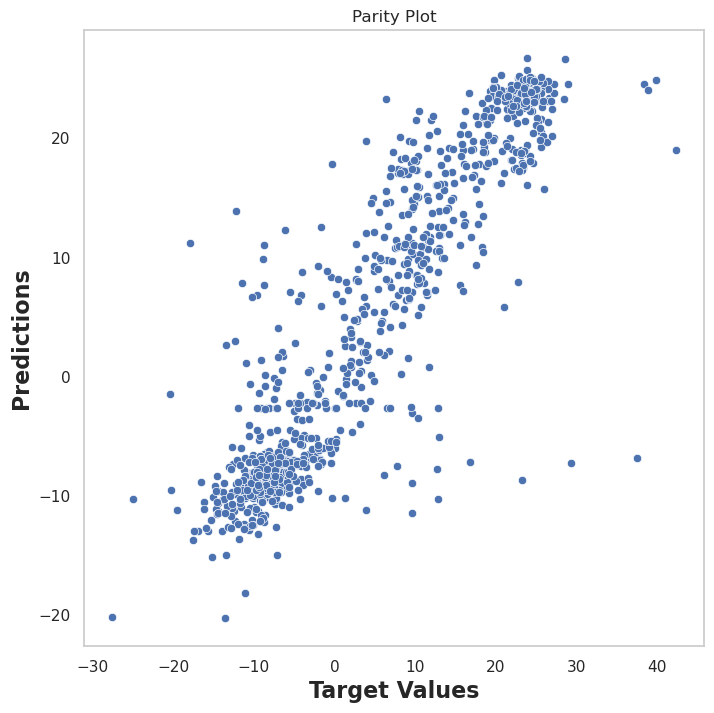

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt

model_predictions_node = []
target_values = []
model_node_only.eval()
with torch.no_grad():
    for test_data in test_loader:
        batch_predictions_node = model_node_only(test_data)
        model_predictions_node.append(batch_predictions_node.detach().numpy())
        target_values.append(test_data.y.detach().numpy())
        
        
model_predictions_node = np.concatenate(model_predictions_node)
target_values = np.concatenate(target_values)
sns.set(style='whitegrid')
plt.figure(figsize=(8, 8))
sns.scatterplot(x = target_values, y = model_predictions_node.reshape(-1))
#sns.lineplot(x = target_values.reshape(-1), y = target_values.reshape(-1), color = 'red')
r2 = r2_score(target_values, model_predictions_node.reshape(-1))
plt.xlabel('Target Values', fontsize=16, fontweight='bold', fontname='Helvetica')
plt.ylabel('Predictions', fontsize=16, fontweight='bold', fontname='Helvetica')
plt.title('Parity Plot')
plt.grid(False)
plt.show()

In [33]:
sns_plot_df_node = pd.DataFrame({"Target_predictions": target_values, "Model_predictions_node": model_predictions_node.reshape(-1)})

/tmp/ipykernel_1836703/3695088294.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticks(), size = 15, weight = 'bold')
/tmp/ipykernel_1836703/3695088294.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticks(), size = 15, weight = 'bold')


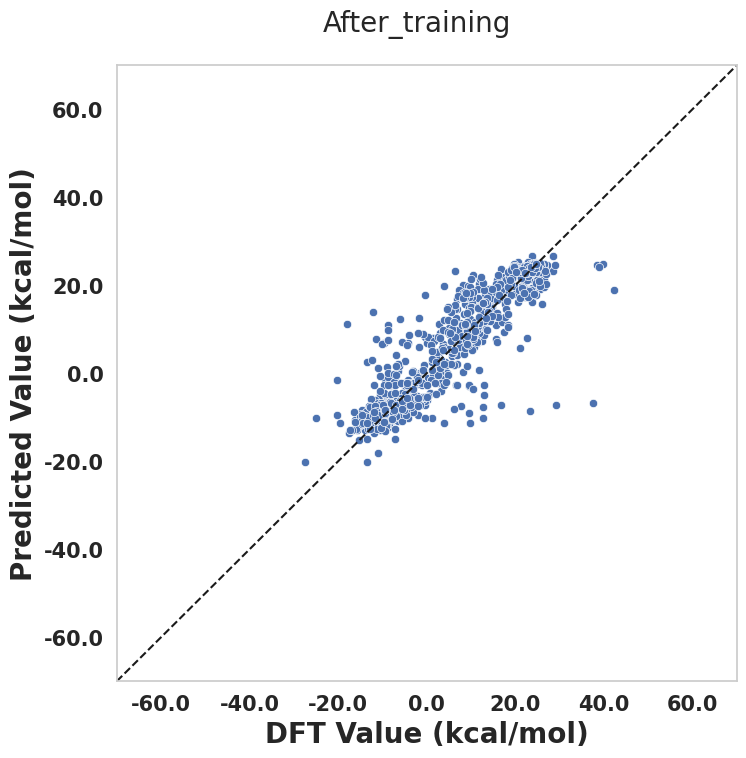

In [34]:
# Set the Seaborn style (optional)
f, ax = plt.subplots(figsize=(8, 8))
#sns.set(font="Helvetica")
sns.set(style="whitegrid")

sns.set_palette('pastel')
ax = sns.scatterplot(x="Target_predictions", y="Model_predictions_node", data=sns_plot_df_node, marker = 'o')
f.suptitle('After_training', y =0.95, fontsize=20)

ax.set_xlabel("DFT Value (kcal/mol)",size = 20,alpha=1, weight = 'bold')
ax.set_ylabel("Predicted Value (kcal/mol)",size = 20,alpha=1, weight='bold')
ax.set_xlim(-70,70)
ax.set_ylim(-70,70)
ax.set_yticklabels(ax.get_yticks(), size = 15, weight = 'bold')
ax.set_xticklabels(ax.get_xticks(), size = 15, weight = 'bold')
plt.grid(False)
X_plot = np.linspace(-70, 70, 100)
Y_plot = X_plot
plt.plot(X_plot, Y_plot, 'k--')
plt.show()

In [35]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

def rmse(y_actual, y_predicted):
    mse = mean_squared_error(y_actual, y_predicted)
    return np.sqrt(mse)

def mean_ae(y_actual, y_predicted):
    mean_ae = mean_absolute_error(y_actual, y_predicted)
    return mean_ae

r2_test = r2_score(sns_plot_df_node['Target_predictions'], sns_plot_df_node['Model_predictions_node'])
r2_test

rmse_test = rmse(sns_plot_df_node['Target_predictions'], sns_plot_df_node['Model_predictions_node'])
mae_test = mean_ae(sns_plot_df_node['Target_predictions'], sns_plot_df_node['Model_predictions_node'])
print(f"Root Mean Squared Error (RMSE): {rmse_test:.4f}, r2_score: {r2_test}, MAE: {mae_test}")

Root Mean Squared Error (RMSE): 5.4902, r2_score: 0.8352544481554809, MAE: 3.4808733463287354


In [36]:
fn_info = []
smi_info = []
import math
for i,j in sns_plot_df_node.iterrows():
    chk_val = j['Target_predictions']
    fg = refine_df_test.iloc[(refine_df_test['dG_sp'] - chk_val).abs().argsort()[0]].functional_group_reacted
    smi = refine_df_test.iloc[(refine_df_test['dG_sp'] - chk_val).abs().argsort()[0]].reactant_smiles
    fn_info.append(fg)
    smi_info.append(smi)
    
    
sns_plot_df_node['functional_group_reacted'] = fn_info
sns_plot_df_node['reactant_smiles'] = smi_info

In [37]:
sns_plot_df_node

,Target_predictions,Model_predictions_node,functional_group_reacted,reactant_smiles
0,9.261597,11.392411,lactone,CCC1=NCC(=O)O1
1,23.787022,23.389816,amide,NC(=O)[C@@H]1[C@H]2C[C@H]3[C@@H]1C[C@@H]23
2,8.582149,9.476609,lactone,C#C[C@H]1C[C@H](O)C(=O)O1
3,-6.323540,-7.887905,nitrile,C[C@@H](C#N)N(C)C
4,-14.002698,-12.970164,nitrile,N#CCn1nnnn1
...,...,...,...,...
995,20.194920,23.113283,lactam,CC(C)[C@H]1CCNC1=O
996,-9.430855,-8.272998,nitrile,N#C[C@H](CO)N1CC1
997,-5.677054,-8.161433,nitrile,C[C@@]1(N)[C@@H](O)[C@]1(C)C#N
998,0.168894,-2.610835,lactam,N[C@@H]1C(=O)N[C@H]1C(=O)O


In [38]:
sns_plot_df_node.to_json('reactant_preds_node_only.json')

In [40]:
from bondnet.hepom_reac_only.layer.gcn_node_edge import GCN_regressor_w_bond
best_val_loss_node_edge = float('inf')
best_model_state_node_edge= None

model = GCN_regressor_w_bond(atom_feature_dim=dataset.feature_size['atom'],
                             bond_feature_dim=dataset.feature_size['bond'],
                             node_hidden_channels_1=64,
                             edge_hidden_channels_1=64,
                             message_channels=32)
criterion = nn.MSELoss()
print(model)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

GCN_regressor_w_bond(
  (node_conv1): GCNConv(19, 64)
  (node_conv2): GCNConv(64, 64)
  (node_conv3): GCNConv(64, 19)
  (edge_conv1): GCNConv(6, 64)
  (edge_conv2): GCNConv(64, 64)
  (edge_conv3): GCNConv(64, 6)
  (node_transform): Linear(in_features=19, out_features=32, bias=True)
  (message_transform): Linear(in_features=38, out_features=19, bias=True)
  (fc1): Linear(in_features=20, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=1, bias=True)
)


In [41]:
import time
for epoch in range(251):
    model.train()
    
    for data in train_loader:
        optimizer.zero_grad()
        predictions = model(data)
        target = data.y.unsqueeze(1)
        loss = criterion(predictions, target)
        loss.backward()
        optimizer.step()

    # Validate the model
    model.eval()
    
    with torch.no_grad():
        for val_data in val_loader:            
            val_predictions = model(val_data)
            val_loss = criterion(val_predictions, val_data.y.unsqueeze(1))

    # Keep track of the best model based on validation loss
    if val_loss < best_val_loss_node_edge:
        best_val_loss_node_edge = val_loss
        best_model_state_node_edge = model.state_dict()
    
    if ((epoch % 50) == 0):
        print(f'Epoch: {epoch}, Validation Loss: {val_loss}')

Epoch: 0, Validation Loss: 52.09272003173828
Epoch: 50, Validation Loss: 47.485469818115234
Epoch: 100, Validation Loss: 20.236114501953125
Epoch: 150, Validation Loss: 50.71354675292969
Epoch: 200, Validation Loss: 16.07889747619629
Epoch: 250, Validation Loss: 26.18934440612793


In [42]:
print(best_val_loss_node_edge)
model.load_state_dict(best_model_state_node_edge)

model.eval()
with torch.no_grad():
    for test_data in test_loader:
        test_predictions_node_edge = model(test_data)
        test_loss_node_edge = criterion(test_predictions_node_edge, test_data.y.unsqueeze(1))

tensor(8.3556)


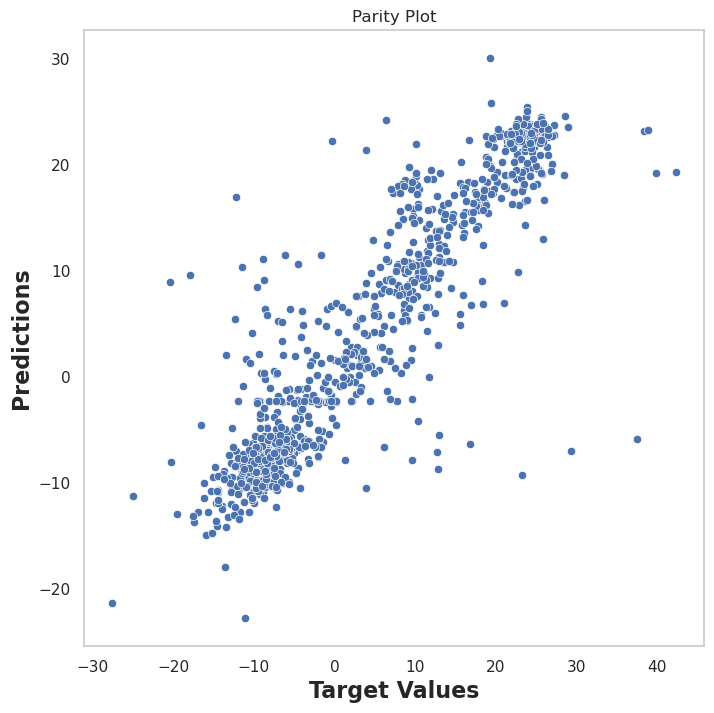

In [43]:
model_predictions_node_edge = []
target_values = []
model.eval()
with torch.no_grad():
    for test_data in test_loader:
        batch_predictions_node_edge = model(test_data)
        model_predictions_node_edge.append(batch_predictions_node_edge.detach().numpy())
        target_values.append(test_data.y.detach().numpy())
        
        
model_predictions_node_edge = np.concatenate(model_predictions_node_edge)
target_values = np.concatenate(target_values)
sns.set(style='whitegrid')
plt.figure(figsize=(8, 8))
sns.scatterplot(x = target_values, y = model_predictions_node_edge.reshape(-1))
#sns.lineplot(x = target_values.reshape(-1), y = target_values.reshape(-1), color = 'red')
r2 = r2_score(target_values, model_predictions_node_edge.reshape(-1))
plt.xlabel('Target Values', fontsize=16, fontweight='bold', fontname='Helvetica')
plt.ylabel('Predictions', fontsize=16, fontweight='bold', fontname='Helvetica')
plt.title('Parity Plot')
plt.grid(False)
plt.show()

In [44]:
sns_plot_df_node_edge = pd.DataFrame({"Target_predictions": target_values, "Model_predictions_node_edge": model_predictions_node_edge.reshape(-1)})

/tmp/ipykernel_1836703/1961702790.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticks(), size = 15, weight = 'bold')
/tmp/ipykernel_1836703/1961702790.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticks(), size = 15, weight = 'bold')


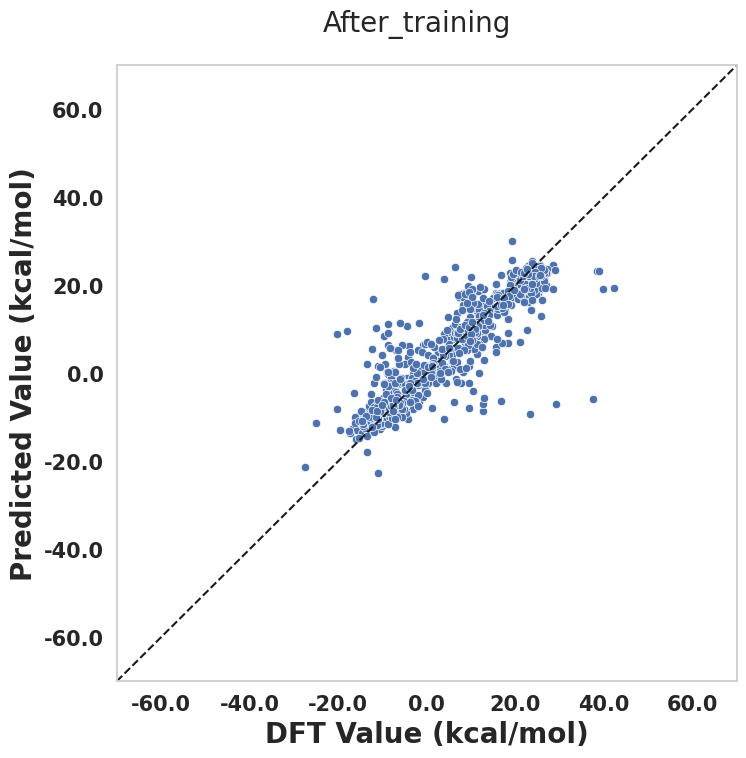

In [45]:
# Set the Seaborn style (optional)
f, ax = plt.subplots(figsize=(8, 8))
#sns.set(font="Helvetica")
sns.set(style="whitegrid")

sns.set_palette('pastel')
ax = sns.scatterplot(x="Target_predictions", y="Model_predictions_node_edge", data=sns_plot_df_node_edge, marker = 'o')
f.suptitle('After_training', y =0.95, fontsize=20)

ax.set_xlabel("DFT Value (kcal/mol)",size = 20,alpha=1, weight = 'bold')
ax.set_ylabel("Predicted Value (kcal/mol)",size = 20,alpha=1, weight='bold')
ax.set_xlim(-70,70)
ax.set_ylim(-70,70)
ax.set_yticklabels(ax.get_yticks(), size = 15, weight = 'bold')
ax.set_xticklabels(ax.get_xticks(), size = 15, weight = 'bold')
plt.grid(False)
X_plot = np.linspace(-70, 70, 100)
Y_plot = X_plot
plt.plot(X_plot, Y_plot, 'k--')
plt.show()

In [46]:
fn_info = []
smi_info = []
import math
for i,j in sns_plot_df_node_edge.iterrows():
    chk_val = j['Target_predictions']
    fg = refine_df_test.iloc[(refine_df_test['dG_sp'] - chk_val).abs().argsort()[0]].functional_group_reacted
    smi = refine_df_test.iloc[(refine_df_test['dG_sp'] - chk_val).abs().argsort()[0]].reactant_smiles
    fn_info.append(fg)
    smi_info.append(smi)
    
    
sns_plot_df_node_edge['functional_group_reacted'] = fn_info
sns_plot_df_node_edge['reactant_smiles'] = smi_info

In [49]:
rmse_test = rmse(sns_plot_df_node_edge['Target_predictions'], sns_plot_df_node_edge['Model_predictions_node_edge'])
mae_test = mean_ae(sns_plot_df_node_edge['Target_predictions'], sns_plot_df_node_edge['Model_predictions_node_edge'])
print(f"Root Mean Squared Error (RMSE): {rmse_test:.4f}, r2_score: {r2_test}, MAE: {mae_test}")

Root Mean Squared Error (RMSE): 5.3963, r2_score: 0.8352544481554809, MAE: 3.312288999557495


In [50]:
sns_plot_df_node_edge.to_json('reactant_preds_node_edge.json')